In [1]:
# If anything is missing, uncomment the next line and run once:
# !pip install pretty_midi music21 librosa scikit-learn tensorflow matplotlib -q

import os, math, random, warnings, gc
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt

import pretty_midi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Parameters you can tweak
TARGET_COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]
MAX_SEQ_LEN = 1024        # tokens for LSTM
DUR_QUANT   = 0.05        # seconds -> duration bucket size
FS          = 16          # frames per second for piano-roll
MAX_TIME    = 30.0        # seconds per example for piano-roll
BATCH_SIZE  = 16
EPOCHS      = 30

# Vocab sizes for embeddings (keep these as-is)
PITCH_VOCAB = 128 + 1     # 0..127 + padding(0)
DUR_VOCAB   = 1000 + 1    # 0..1000 (0 is padding)


## 1) Load file list from folders

In [3]:
ROOT = Path(".").resolve()
rows = []
for comp in TARGET_COMPOSERS:
    d = ROOT/comp
    if not d.exists():
        print(f"⚠️ Missing folder: {d}")
        continue
    # recursive search for .mid/.midi
    for p in d.rglob("*"):
        if p.is_file() and p.suffix.lower() in [".mid", ".midi"]:
            rows.append({"path": str(p), "composer": comp})

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No MIDI files found in Bach/Beethoven/Chopin/Mozart folders.")
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Loaded files per composer:")
print(df["composer"].value_counts())
df.head()


Loaded files per composer:
composer
Bach         1027
Mozart        257
Beethoven     213
Chopin        136
Name: count, dtype: int64


,path,composer
0,C:\Users\PR\AIsandiego\AAI -511\Module7\Projec...,Bach
1,C:\Users\PR\AIsandiego\AAI -511\Module7\Projec...,Mozart
2,C:\Users\PR\AIsandiego\AAI -511\Module7\Projec...,Bach
3,C:\Users\PR\AIsandiego\AAI -511\Module7\Projec...,Bach
4,C:\Users\PR\AIsandiego\AAI -511\Module7\Projec...,Bach


## 2) Train/Val/Test split + label encoding

In [5]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["composer"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

train_df, test_df = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df["label"])

len(train_df), len(val_df), len(test_df)


Classes: ['Bach', 'Beethoven', 'Chopin', 'Mozart']


(1179, 209, 245)

## 3) MIDI parsing + feature builders

In [7]:
def load_pm(path):
    try:
        return pretty_midi.PrettyMIDI(path)
    except Exception as e:
        print(f"[WARN] Could not parse {path}: {e}")
        return None

def extract_notes(pm):
    """Return list of (pitch, duration_seconds) from all non-drum tracks."""
    notes = []
    if pm is None:
        return notes
    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            dur = max(1e-3, n.end - n.start)
            notes.append((n.pitch, dur))
    # keep as-is; no sorting needed beyond original order
    return notes

def to_token_sequence(notes, max_len=MAX_SEQ_LEN, duration_quant=DUR_QUANT):
    """
    Map notes -> fixed-length sequence of (pitch, dur_bucket).
    Pads with (0,0). Clips to vocab ranges.
    """
    seq = []
    for (pitch, dur) in notes:
        pitch = int(np.clip(int(pitch), 0, 127))
        dur_bucket = int(np.clip(round(dur / duration_quant), 1, 1000))  # 1..1000; 0 reserved for pad
        seq.append((pitch, dur_bucket))
        if len(seq) >= max_len:
            break
    if len(seq) < max_len:
        seq += [(0,0)] * (max_len - len(seq))
    return np.array(seq, dtype=np.int32)

def build_pianoroll(pm, fs=FS, max_time=MAX_TIME):
    """
    Build binarized piano-roll of shape (T, 128). T = fs * max_time.
    """
    T = int(fs * max_time)
    roll = np.zeros((T, 128), dtype=np.float32)
    if pm is None:
        return roll
    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            if n.start >= max_time:
                continue
            s = int(np.clip(math.floor(n.start*fs), 0, T-1))
            e = int(np.clip(math.ceil(min(n.end, max_time)*fs), 0, T))
            roll[s:e, n.pitch] = 1.0
    return roll


## 4) Light augmentation for training

In [9]:
AUG_TRANSPOSE = [-2, -1, 0, 1, 2]   # semitones
AUG_STRETCH   = [0.95, 1.0, 1.05]   # tempo stretch

def transpose_notes(notes, semitones):
    if semitones == 0: 
        return notes
    out = []
    for p,d in notes:
        out.append((int(np.clip(p + semitones, 0, 127)), d))
    return out

def stretch_notes(notes, factor):
    if abs(factor - 1.0) < 1e-6:
        return notes
    out = []
    for p,d in notes:
        out.append((p, max(1e-3, d * factor)))
    return out


## 5) Build arrays

In [11]:
def build_split_arrays(frame, augment=False):
    X_seq, X_roll, y = [], [], []
    for _, r in frame.iterrows():
        pm = load_pm(r["path"])
        notes = extract_notes(pm)

        if augment:
            t = random.choice(AUG_TRANSPOSE)
            s = random.choice(AUG_STRETCH)
            notes = transpose_notes(notes, t)
            notes = stretch_notes(notes, s)

        seq = to_token_sequence(notes, max_len=MAX_SEQ_LEN, duration_quant=DUR_QUANT)
        roll = build_pianoroll(pm, fs=FS, max_time=MAX_TIME)

        X_seq.append(seq)
        X_roll.append(roll)
        y.append(r["label"])

    X_seq = np.stack(X_seq)       # (N, T, 2)
    X_roll = np.stack(X_roll)     # (N, T, 128)
    y = np.array(y, dtype=np.int64)
    return X_seq, X_roll, y

Xseq_train, Xroll_train, y_train = build_split_arrays(train_df, augment=True)
Xseq_val,   Xroll_val,   y_val   = build_split_arrays(val_df,   augment=False)
Xseq_test,  Xroll_test,  y_test  = build_split_arrays(test_df,  augment=False)

# Split sequence into separate inputs (pitch, duration) and enforce bounds/dtypes
Xseq_train_pitch = np.clip(Xseq_train[:,:,0].astype("int32"), 0, 127)
Xseq_train_dur   = np.clip(Xseq_train[:,:,1].astype("int32"), 0, 1000)
Xseq_val_pitch   = np.clip(Xseq_val[:,:,0].astype("int32"),   0, 127)
Xseq_val_dur     = np.clip(Xseq_val[:,:,1].astype("int32"),   0, 1000)
Xseq_test_pitch  = np.clip(Xseq_test[:,:,0].astype("int32"),  0, 127)
Xseq_test_dur    = np.clip(Xseq_test[:,:,1].astype("int32"),  0, 1000)

# CNN inputs need a channel dimension
Xroll_train_cnn = Xroll_train[..., None].astype("float32")
Xroll_val_cnn   = Xroll_val[..., None].astype("float32")
Xroll_test_cnn  = Xroll_test[..., None].astype("float32")

print("Shapes:")
print(" LSTM pitch:", Xseq_train_pitch.shape, Xseq_val_pitch.shape, Xseq_test_pitch.shape)
print(" LSTM dur  :", Xseq_train_dur.shape,   Xseq_val_dur.shape,   Xseq_test_dur.shape)
print(" CNN roll  :", Xroll_train_cnn.shape,  Xroll_val_cnn.shape,  Xroll_test_cnn.shape)

print("Pitch maxes (train/val/test):", Xseq_train_pitch.max(), Xseq_val_pitch.max(), Xseq_test_pitch.max())
print("Dur maxes   (train/val/test):", Xseq_train_dur.max(), Xseq_val_dur.max(), Xseq_test_dur.max())


[WARN] Could not parse C:\Users\PR\AIsandiego\AAI -511\Module7\Project_PR\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
[WARN] Could not parse C:\Users\PR\AIsandiego\AAI -511\Module7\Project_PR\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Shapes:
 LSTM pitch: (1179, 1024) (209, 1024) (245, 1024)
 LSTM dur  : (1179, 1024) (209, 1024) (245, 1024)
 CNN roll  : (1179, 480, 128, 1) (209, 480, 128, 1) (245, 480, 128, 1)
Pitch maxes (train/val/test): 104 103 100
Dur maxes   (train/val/test): 487 464 385


## 6) Class weights + callbacks

In [13]:
classes = np.arange(num_classes)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {i: w for i, w in zip(classes, cw)}
class_weights


{0: 0.3972371967654987,
 1: 1.9139610389610389,
 2: 3.00765306122449,
 3: 1.5932432432432433}

In [15]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
]


## 7) Build models
# 7A) LSTM 

7B) CNN (piano-roll as image)

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

PITCH_VOCAB = 128 + 1     # 0..127 + padding(0)
DUR_VOCAB   = 1000 + 1    # 0..1000 (0 is padding)

def build_lstm_model(max_len=MAX_SEQ_LEN, num_classes=len(le.classes_),
                     pitch_emb=32, dur_emb=32, lstm_units=128, dropout=0.3):
    pitch_in = layers.Input(shape=(max_len,), dtype="int32", name="pitch_in")
    dur_in   = layers.Input(shape=(max_len,), dtype="int32", name="dur_in")

    # ✅ Clip indices INSIDE the graph to valid ranges
    pitch_idx = layers.Lambda(lambda x: tf.clip_by_value(x, 0, PITCH_VOCAB-1),
                              name="clip_pitch")(pitch_in)
    dur_idx   = layers.Lambda(lambda x: tf.clip_by_value(x, 0, DUR_VOCAB-1),
                              name="clip_dur")(dur_in)

    # No masking to avoid broadcast issues
    pitch_e = layers.Embedding(PITCH_VOCAB, pitch_emb, mask_zero=False, name="pitch_emb")(pitch_idx)
    dur_e   = layers.Embedding(DUR_VOCAB,   dur_emb,   mask_zero=False, name="dur_emb")(dur_idx)

    x = layers.Concatenate(name="concat_feat")([pitch_e, dur_e])
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model([pitch_in, dur_in], out, name="ComposerLSTM")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

keras.backend.clear_session()
lstm_model = build_lstm_model()
lstm_model.summary()


Model: "ComposerLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dur_in (InputLayer) │ (None, 1024)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clip_pitch (Lambda) │ (None, 1024)      │          0 │ pitch_in[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clip_dur (Lambda)   │ (None, 1024)      │          0 │ dur_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch_emb           │ (None, 1024, 32)  │      4,128 │ clip_pitch[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dur_emb (Embedding) │ (None, 1024, 32)  │     32,032 │ clip_dur[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_feat         │ (None, 1024, 64)  │          0 │ pitch_emb[0][0],  │
│ (Concatenate)       │                   │            │ dur_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1024, 256) │    197,632 │ concat_feat[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    394,240 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        516 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 661,444 (2.52 MB)

 Trainable params: 661,444 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Ensure type + contiguous memory (Windows/NumPy sometimes gets cranky)
Xseq_train_pitch = np.ascontiguousarray(Xseq_train_pitch.astype("int32"))
Xseq_train_dur   = np.ascontiguousarray(Xseq_train_dur.astype("int32"))
Xseq_val_pitch   = np.ascontiguousarray(Xseq_val_pitch.astype("int32"))
Xseq_val_dur     = np.ascontiguousarray(Xseq_val_dur.astype("int32"))
Xseq_test_pitch  = np.ascontiguousarray(Xseq_test_pitch.astype("int32"))
Xseq_test_dur    = np.ascontiguousarray(Xseq_test_dur.astype("int32"))


In [30]:
hist_lstm = lstm_model.fit(
    x={"pitch_in": Xseq_train_pitch, "dur_in": Xseq_train_dur},
    y=y_train,
    validation_data=([Xseq_val_pitch, Xseq_val_dur], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.4970 - loss: 1.3402 - val_accuracy: 0.5359 - val_loss: 1.3034 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5314 - loss: 1.2686 - val_accuracy: 0.1340 - val_loss: 1.3952 - learning_rate: 0.0010
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5171 - loss: 1.2266 - val_accuracy: 0.1531 - val_loss: 1.5169 - learning_rate: 0.0010
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5782 - loss: 1.1671 - val_accuracy: 0.1435 - val_loss: 1.6372 - learning_rate: 0.0010
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5817 - loss: 1.0751 - val_accuracy: 0.1005 - val_loss: 1.7576 - learning_rate: 5.0000e-04
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.6413 - loss: 1.0073 - val_accuracy: 0.2392 - val_loss: 1.6148 - learning_rate: 5.0000e-04


## 7B) CNN

In [32]:
cnn_model = build_cnn_model(Xroll_train_cnn.shape[1:])
cnn_model.summary()

hist_cnn = cnn_model.fit(
    x=Xroll_train_cnn, y=y_train,
    validation_data=(Xroll_val_cnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Model: "ComposerCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 480, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 480, 128, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 240, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 240, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 120, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 120, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,212 (430.52 KB)

 Trainable params: 110,212 (430.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 353ms/step - accuracy: 0.2559 - loss: 1.4029 - val_accuracy: 0.1148 - val_loss: 1.3877 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.1682 - loss: 1.3987 - val_accuracy: 0.0861 - val_loss: 1.4075 - learning_rate: 0.0010
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - accuracy: 0.1274 - loss: 1.3974 - val_accuracy: 0.0909 - val_loss: 1.4299 - learning_rate: 0.0010
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 370ms/step - accuracy: 0.1207 - loss: 1.3860 - val_accuracy: 0.1340 - val_loss: 1.3670 - learning_rate: 0.0010
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 370ms/step - accuracy: 0.2505 - loss: 1.3634 - val_accuracy: 0.5646 - val_loss: 1.2682 - learning_rate: 0.0010
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 362ms/step - accuracy: 0.5111 - loss: 1.3313 - val_accuracy: 0.6077 - val_loss: 1.1924 - learning_rate: 0.0010
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 358ms/step - accuracy: 0.5317 - loss: 1.

## Evalation of Models



ComposerLSTM — Test Accuracy: 0.551 | Macro-Precision: 0.476 | Macro-Recall: 0.476

              precision    recall  f1-score   support

        Bach       0.87      0.64      0.74       154
   Beethoven       0.30      0.53      0.39        32
      Chopin       0.17      0.50      0.25        20
      Mozart       0.56      0.23      0.33        39

    accuracy                           0.55       245
   macro avg       0.48      0.48      0.43       245
weighted avg       0.69      0.55      0.59       245



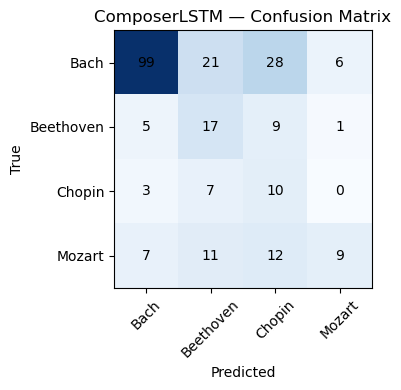


ComposerCNN — Test Accuracy: 0.702 | Macro-Precision: 0.533 | Macro-Recall: 0.513

              precision    recall  f1-score   support

        Bach       0.89      0.88      0.89       154
   Beethoven       0.26      0.16      0.20        32
      Chopin       0.60      0.45      0.51        20
      Mozart       0.38      0.56      0.45        39

    accuracy                           0.70       245
   macro avg       0.53      0.51      0.51       245
weighted avg       0.70      0.70      0.70       245



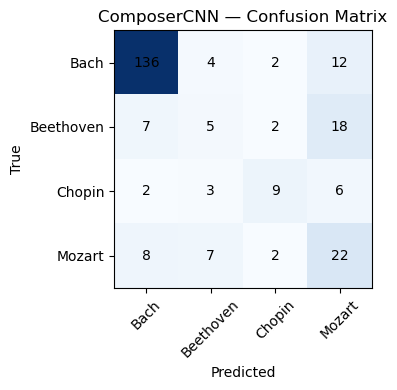

In [34]:
def eval_and_report(model, X, y_true, model_type, class_names):
    import numpy as np, matplotlib.pyplot as plt
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

    if model_type == "LSTM":
        y_prob = model.predict({"pitch_in": X[0], "dur_in": X[1]}, verbose=0)
    else:
        y_prob = model.predict(X, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro",  zero_division=0)
    print(f"\n{model.name} — Test Accuracy: {acc:.3f} | Macro-Precision: {prec:.3f} | Macro-Recall: {rec:.3f}\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{model.name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()

# LSTM
eval_and_report(
    lstm_model,
    (Xseq_test_pitch, Xseq_test_dur),
    y_test,
    model_type="LSTM",
    class_names=list(le.classes_)
)

# CNN
eval_and_report(
    cnn_model,
    Xroll_test_cnn,
    y_test,
    model_type="CNN",
    class_names=list(le.classes_)
)


## Do a quick ensemble (often boosts accuracy a bit)

In [37]:
import numpy as np
# Probabilities
prob_lstm = lstm_model.predict({"pitch_in": Xseq_test_pitch, "dur_in": Xseq_test_dur}, verbose=0)
prob_cnn  = cnn_model.predict(Xroll_test_cnn, verbose=0)

# Simple average (you can also try weighted averages e.g., 0.6*LSTM + 0.4*CNN)
prob_ens = (prob_lstm + prob_cnn) / 2.0
y_pred_ens = np.argmax(prob_ens, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
acc  = accuracy_score(y_test, y_pred_ens)
prec = precision_score(y_test, y_pred_ens, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred_ens, average="macro", zero_division=0)
print(f"\nEnsemble — Test Accuracy: {acc:.3f} | Macro-Precision: {prec:.3f} | Macro-Recall: {rec:.3f}\n")
print(classification_report(y_test, y_pred_ens, target_names=list(le.classes_), zero_division=0))



Ensemble — Test Accuracy: 0.714 | Macro-Precision: 0.524 | Macro-Recall: 0.515

              precision    recall  f1-score   support

        Bach       0.89      0.90      0.89       154
   Beethoven       0.30      0.22      0.25        32
      Chopin       0.47      0.40      0.43        20
      Mozart       0.44      0.54      0.48        39

    accuracy                           0.71       245
   macro avg       0.52      0.51      0.52       245
weighted avg       0.70      0.71      0.71       245



## Save everything

In [40]:
lstm_model.save("model_lstm.keras")
cnn_model.save("model_cnn.keras")
np.save("y_test.npy", y_test)
np.save("prob_lstm.npy", prob_lstm)
np.save("prob_cnn.npy", prob_cnn)
with open("labels.txt", "w") as f:
    for i, name in enumerate(le.classes_):
        f.write(f"{i}\t{name}\n")
print("Saved models, probs, and labels.")


Saved models, probs, and labels.
